# Market Prices

Data obtained from [REN Datahub](https://mercado.ren.pt/PT/Electr/InfoMercado/InfOp/MercOmel/Paginas/Precos.aspx).

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import xgboost as xgb

warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_excel("../data/PrecoMerc.xlsx")
df.head()

In [ ]:
df.columns = ["date", "hour", "session", "price_pt", "price_es"]
df = df[df['session'] == 0][["date", "hour", "price_pt"]]
df.head()

,date,hour,price_pt
0,2008-07-01,1,70.31
1,2008-07-01,2,64.54
2,2008-07-01,3,64.08
3,2008-07-01,4,63.50
4,2008-07-01,5,63.28


In [ ]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["hour"] = pd.to_timedelta(df["hour"], unit="h")
df["date"] = df["date"] + df["hour"]
df.head()

,date,hour,price_pt
0,2008-07-01 01:00:00,0 days 01:00:00,70.31
1,2008-07-01 02:00:00,0 days 02:00:00,64.54
2,2008-07-01 03:00:00,0 days 03:00:00,64.08
3,2008-07-01 04:00:00,0 days 04:00:00,63.50
4,2008-07-01 05:00:00,0 days 05:00:00,63.28


In [ ]:
df = df[["date", "price_pt"]]
df.rename(columns={"price_pt": "price"}, inplace=True)
df.head()

,date,price
0,2008-07-01 01:00:00,70.31
1,2008-07-01 02:00:00,64.54
2,2008-07-01 03:00:00,64.08
3,2008-07-01 04:00:00,63.50
4,2008-07-01 05:00:00,63.28


In [ ]:
# df.to_csv("../data/MarketPricePT.csv", index=False)

# Simulation

In this section, we will simulate the management system of the REC.

## Baseline

In [2]:
try:
    df
except NameError:
    df = pd.read_csv("../data/MarketPricePT.csv", parse_dates=["date"])

In [3]:
df.head()

,date,price
0,2008-07-01 01:00:00,70.31
1,2008-07-01 02:00:00,64.54
2,2008-07-01 03:00:00,64.08
3,2008-07-01 04:00:00,63.50
4,2008-07-01 05:00:00,63.28


In [4]:
energy_df = pd.read_csv("../data/BANES_v4_featureimportance.csv")
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
0,##Bishop Sutton Primary School Electricity,2017-01-08 00:00:00+00:00,0.000,0.000,0.000,0.005,0.000,0.000,0.000
1,##Bishop Sutton Primary School Electricity,2017-01-08 00:30:00+00:00,0.000,0.000,0.005,0.005,0.005,0.000,0.000
2,##Bishop Sutton Primary School Electricity,2017-01-08 01:00:00+00:00,0.000,0.000,0.005,0.006,0.005,0.005,0.000
3,##Bishop Sutton Primary School Electricity,2017-01-08 01:30:00+00:00,0.006,0.000,0.006,0.005,0.006,0.005,0.005
4,##Bishop Sutton Primary School Electricity,2017-01-08 02:00:00+00:00,0.005,0.006,0.005,0.005,0.005,0.006,0.005


In [5]:
# pick 10 locations at random
locs = energy_df.sample(10, random_state=1).index.tolist()
locations = energy_df.iloc[locs]["location"]
assert len(locations) == 10 and len(np.unique(locations)) == 10
energy_df = energy_df[energy_df["location"].isin(locations)]
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338


In [6]:
model: xgb.XGBRegressor = pickle.load(open("../models/model_v1.pkl", "rb"))

In [7]:
X = energy_df.drop(["location", "time", "energy"], axis=1)
y = model.predict(X)

In [8]:
energy_df["energy_pred"] = y
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334,0.347339
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335,0.347339
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334,0.347339
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333,0.347339
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338,0.332923


In [9]:
# group by date and sum the energy_pred
energy_df = energy_df.groupby("time").sum()
energy_df.head()

,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
time,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.4145,15.6905,19.0515,13.7410,13.665,10.4265,12.346559
2017-01-08 00:30:00+00:00,15.5335,12.1005,15.7690,16.3645,14.3410,13.741,13.6650,13.528800
2017-01-08 01:00:00+00:00,15.8120,15.5335,15.9685,15.1790,13.9740,14.341,13.7410,15.156461
2017-01-08 01:30:00+00:00,15.2760,15.8120,15.6965,14.6085,13.7320,13.974,14.3410,15.276405
2017-01-08 02:00:00+00:00,15.6635,15.2760,15.5890,14.2770,13.7605,13.732,13.9740,14.978525


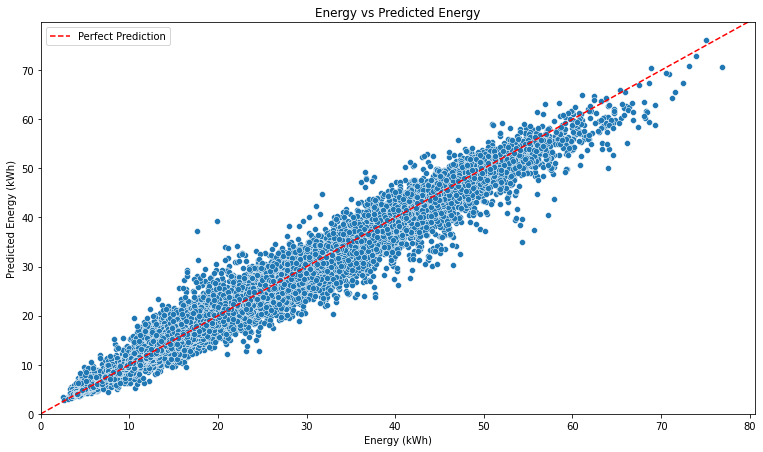

In [10]:
plt.figure(figsize=(12.8, 7.2))

sns.scatterplot(data=energy_df, x="energy", y="energy_pred")
plt.xlabel("Energy (kWh)")
plt.ylabel("Predicted Energy (kWh)")
plt.title("Energy vs Predicted Energy")
plt.xlim(0, None)
plt.ylim(0, None)
plt.plot([0, 100], [0, 100], "r--")
plt.legend(["Perfect Prediction"])
plt.show()

<Figure size 921.6x518.4 with 0 Axes>

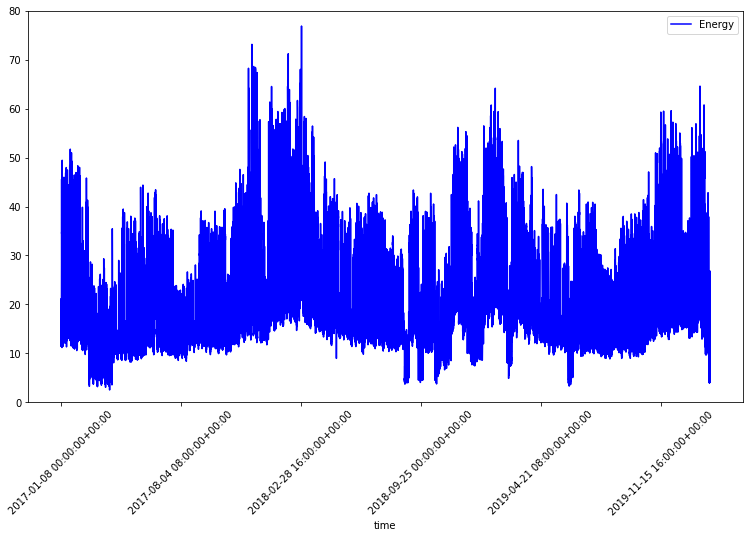

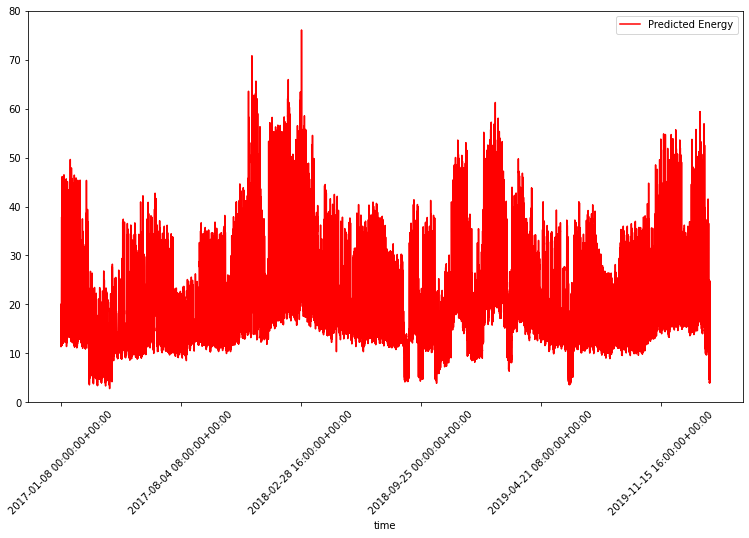

In [11]:
plt.figure(figsize=(12.8, 7.2))

energy_df.plot(y="energy", figsize=(12.8, 7.2), c="b", label="Energy")
plt.ylim(0, 80)
plt.xticks(rotation=45)
energy_df.plot(y="energy_pred", figsize=(12.8, 7.2), c="r", label="Predicted Energy")
plt.ylim(0, 80)
plt.xticks(rotation=45)
plt.show()

### Energy Production

The production of energy of a solar panel is given by the following equation:

$E(t) = A*r(t)*G(t)*\rho$

Where:

* $E(t)$ is the energy produced in time $t$;
* $A$ is the area of the solar panel;
* $r(t)$ is the is the yield of the solar panel in time $t$;
* $G(t)$ is the Solar irradiance at time $t$;
* $\rho$ is the performance of the solar panel.

In [12]:
simulation = energy_df[["energy", "energy_pred"]]
simulation.head()

,energy,energy_pred
time,,
2017-01-08 00:00:00+00:00,12.1005,12.346559
2017-01-08 00:30:00+00:00,15.5335,13.528800
2017-01-08 01:00:00+00:00,15.8120,15.156461
2017-01-08 01:30:00+00:00,15.2760,15.276405
2017-01-08 02:00:00+00:00,15.6635,14.978525


In [13]:
solar_df = pd.read_csv("../data/Solcast_PT30M.csv")
solar_df.head()

,PeriodEnd,PeriodStart,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
0,2007-01-01T01:00:00Z,2007-01-01T00:30:00Z,PT30M,8.0,0.0,0,11.6,81.4,249,9.9
1,2007-01-01T01:30:00Z,2007-01-01T01:00:00Z,PT30M,7.7,0.0,0,11.3,83.3,251,9.7
2,2007-01-01T02:00:00Z,2007-01-01T01:30:00Z,PT30M,7.3,0.0,0,11.1,85.2,253,9.5
3,2007-01-01T02:30:00Z,2007-01-01T02:00:00Z,PT30M,7.0,0.0,0,10.9,87.2,255,9.4
4,2007-01-01T03:00:00Z,2007-01-01T02:30:00Z,PT30M,6.6,0.0,0,10.7,89.2,256,9.2


In [14]:
solar_df["PeriodStart"] = pd.to_datetime(solar_df["PeriodStart"], format="%Y-%m-%d %H:%M:%S", utc=True)
solar_df["PeriodEnd"] = pd.to_datetime(solar_df["PeriodEnd"], format="%Y-%m-%d %H:%M:%S", utc=True)
simulation.reset_index(inplace=True)
simulation["time"] = pd.to_datetime(simulation["time"], format="%Y-%m-%d %H:%M:%S", utc=True)
solar_df.rename(columns={"PeriodEnd": "time"}, inplace=True)
simulation = simulation.merge(solar_df, on="time", how="left")
simulation.set_index("time", inplace=True)
simulation.head()

,energy,energy_pred,PeriodStart,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
time,,,,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,2017-01-07 23:30:00+00:00,PT30M,8.5,5.3,0,15.7,98.7,257,1.7
2017-01-08 00:30:00+00:00,15.5335,13.528800,2017-01-08 00:00:00+00:00,PT30M,8.4,35.3,0,15.6,98.7,257,1.7
2017-01-08 01:00:00+00:00,15.8120,15.156461,2017-01-08 00:30:00+00:00,PT30M,8.3,47.8,0,15.6,98.7,258,1.7
2017-01-08 01:30:00+00:00,15.2760,15.276405,2017-01-08 01:00:00+00:00,PT30M,8.2,47.8,0,15.5,98.7,260,1.7
2017-01-08 02:00:00+00:00,15.6635,14.978525,2017-01-08 01:30:00+00:00,PT30M,8.1,47.4,0,15.4,98.7,262,1.7


In [15]:
simulation = simulation[["energy", "energy_pred", "Dni"]]
simulation.head()

,energy,energy_pred,Dni
time,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,0
2017-01-08 00:30:00+00:00,15.5335,13.528800,0
2017-01-08 01:00:00+00:00,15.8120,15.156461,0
2017-01-08 01:30:00+00:00,15.2760,15.276405,0
2017-01-08 02:00:00+00:00,15.6635,14.978525,0


In [16]:
simulation["Dni"] = simulation["Dni"] / 1000 

In [17]:
simulation.describe()

,energy,energy_pred,Dni
count,54049.000000,54049.000000,54049.000000
mean,20.287596,20.277138,0.098700
std,10.314216,10.017663,0.221135
min,2.506500,2.785979,0.000000
25%,12.825000,12.937480,0.000000
50%,17.028000,17.320105,0.000000
75%,25.407000,25.322823,0.017000
max,76.893000,76.088570,0.945000


#### Scenario 1

- Goal to improve self-consumption
- no max battery capacity
- no cost of discharging
- no attention to market price


In [18]:
# 18 panels for the community with 1.6 m2 per panel. It generates around 4 kWh at 1 kWh/m2 of Dni.
simulation["production"] = 10 * 18 * 1.6 * 0.15 * simulation["Dni"] * 0.98
# simulation["production"] = 100 * simulation["Dni"]
simulation.head()

,energy,energy_pred,Dni,production
time,,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,0.0,0.0
2017-01-08 00:30:00+00:00,15.5335,13.528800,0.0,0.0
2017-01-08 01:00:00+00:00,15.8120,15.156461,0.0,0.0
2017-01-08 01:30:00+00:00,15.2760,15.276405,0.0,0.0
2017-01-08 02:00:00+00:00,15.6635,14.978525,0.0,0.0


In [19]:
simulation.describe()

,energy,energy_pred,Dni,production
count,54049.000000,54049.000000,54049.000000,54049.000000
mean,20.287596,20.277138,0.098700,4.178550
std,10.314216,10.017663,0.221135,9.361969
min,2.506500,2.785979,0.000000,0.000000
25%,12.825000,12.937480,0.000000,0.000000
50%,17.028000,17.320105,0.000000,0.000000
75%,25.407000,25.322823,0.017000,0.719712
max,76.893000,76.088570,0.945000,40.007520


In [20]:
simulation["battery_charge"] = 0
simulation["losses"] = 0
simulation["grid_energy"] = 0
simulation["send_to_grid"] = 0
simulation["grid_price"] = 0
simulation["saved_to_battery"] = 0
simulation["consumed_from_production"] = 0
simulation["consumed_from_battery"] = 0


In [21]:
simulation.head()

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery
time,,,,,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,0.0,0.0,0,0,0,0,0,0,0,0
2017-01-08 00:30:00+00:00,15.5335,13.528800,0.0,0.0,0,0,0,0,0,0,0,0
2017-01-08 01:00:00+00:00,15.8120,15.156461,0.0,0.0,0,0,0,0,0,0,0,0
2017-01-08 01:30:00+00:00,15.2760,15.276405,0.0,0.0,0,0,0,0,0,0,0,0
2017-01-08 02:00:00+00:00,15.6635,14.978525,0.0,0.0,0,0,0,0,0,0,0,0


In [22]:
BATTERY_CAP = 16
efficiency = 0.96

def baseline_algorithm1(x):
    # energy predicted to consume
    to_consume = x["energy"]

    # if the energy predicted to consume is greater than the energy produced
    if x["production"] < x["energy"]:
        # consume the energy produced
        to_consume -= x["production"]
        x["consumed_from_production"] = x["production"]

        # go fetch the rest to the battery
        if to_consume > x["battery_charge"] * efficiency:
            # if the battery energy is not enough 
            # consume all the energy from the battery
            to_consume -= x["battery_charge"] * efficiency
            x["consumed_from_battery"] = x["battery_charge"] * efficiency
            # add loss from the battery
            x["losses"] = x["battery_charge"] * (1 - efficiency)
            x["battery_charge"] = 0
        else:
            # if the battery energy is enough
            x["battery_charge"] -= to_consume + to_consume * (1 - efficiency)
            x["consumed_from_battery"] = to_consume
            # add loss from the battery
            x["losses"] = to_consume * (1 - efficiency)
            to_consume = 0
    else:
        # if the energy predicted to consume is less than the energy produced
        # consume the energy predicted to consume
        x["consumed_from_production"] = to_consume
        to_consume = 0

        # empty space in the battery
        possible_charge = BATTERY_CAP - x["battery_charge"]
        # add the produced energy to the battery
        x["battery_charge"] += min((x["production"] - x["energy"]) * efficiency, possible_charge)
        # log the energy saved in the battery
        x["saved_to_battery"] = min((x["production"] - x["energy"]) * efficiency, possible_charge)
        x["losses"] = x["saved_to_battery"] * (1 - efficiency) / efficiency
        # send the rest of the energy to the grid
        x["send_to_grid"] = x["production"] - x["saved_to_battery"] - x["losses"]
    
    # fetch the rest of the energy to the grid
    x["grid_energy"] = to_consume
    return x

In [23]:
simulation = simulation.apply(baseline_algorithm1, axis=1)
simulation.reset_index(inplace=True)
simulation["co2_avoided"] = 6.9 * 10 ** -4 * simulation["production"]
simulation["date_minutes"] = pd.to_datetime(simulation["time"]).dt.minute
simulation["date_minutes"] = pd.to_timedelta(simulation["date_minutes"], unit="m")
simulation["date"] = simulation["time"] - simulation["date_minutes"]
simulation["date"] = pd.to_datetime(simulation["date"], utc=True)
df["date"] = pd.to_datetime(df["date"], utc=True)
simulation = simulation.merge(df, on="date", how="left")
simulation["grid_price"] = simulation["grid_energy"] * simulation["price"] / 1000
simulation.drop(["date", "date_minutes"], axis=1, inplace=True)
simulation.set_index("time", inplace=True)
simulation.head()


,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price
time,,,,,,,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,0.0,0.0,0.0,0.0,12.1005,0.0,0.799722,0.0,0.0,0.0,0.0,66.09
2017-01-08 00:30:00+00:00,15.5335,13.528800,0.0,0.0,0.0,0.0,15.5335,0.0,1.026609,0.0,0.0,0.0,0.0,66.09
2017-01-08 01:00:00+00:00,15.8120,15.156461,0.0,0.0,0.0,0.0,15.8120,0.0,1.094190,0.0,0.0,0.0,0.0,69.20
2017-01-08 01:30:00+00:00,15.2760,15.276405,0.0,0.0,0.0,0.0,15.2760,0.0,1.057099,0.0,0.0,0.0,0.0,69.20
2017-01-08 02:00:00+00:00,15.6635,14.978525,0.0,0.0,0.0,0.0,15.6635,0.0,0.956570,0.0,0.0,0.0,0.0,61.07


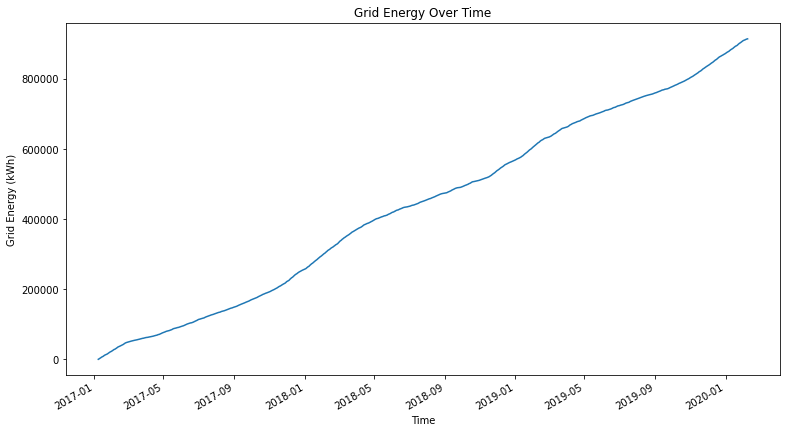

In [24]:
simulation["grid_energy"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Grid Energy (kWh)")
plt.title("Grid Energy Over Time")
plt.show()

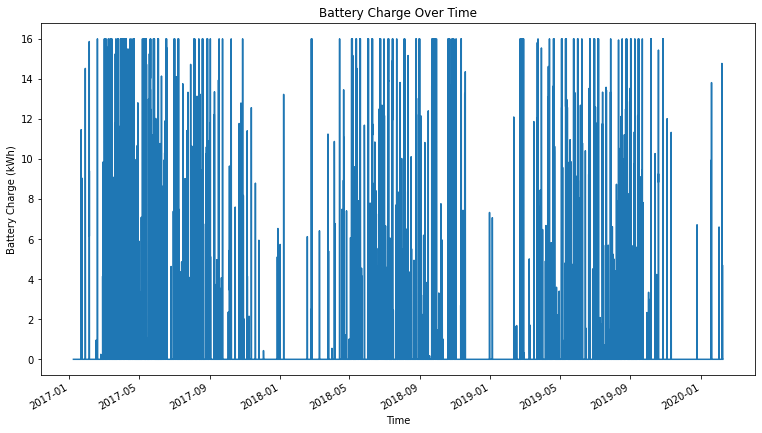

In [25]:
simulation["battery_charge"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Battery Charge (kWh)")
plt.title("Battery Charge Over Time")
plt.show()


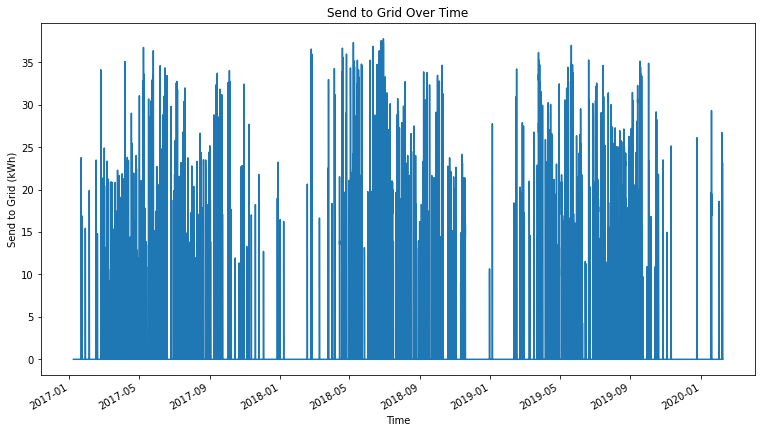

In [26]:
simulation["send_to_grid"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Send to Grid (kWh)")
plt.title("Send to Grid Over Time")
plt.show()

In [27]:
simulation.describe()

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price
count,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54049.000000,54055.000000,54055.000000,54055.0,54055.000000,54049.000000
mean,20.286665,20.276181,0.098689,4.178086,0.720980,0.030041,16.926209,1.647082,0.900752,0.720980,3.360456,0.0,0.002883,52.112591
std,10.314046,10.017546,0.221125,9.361553,2.823821,0.117659,10.917640,5.762580,0.681788,2.823821,7.499119,0.0,0.006459,12.355105
min,2.506500,2.785979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.010000
25%,12.824750,12.937007,0.000000,0.000000,0.000000,0.000000,11.162484,0.000000,0.500882,0.000000,0.000000,0.0,0.000000,44.720000
50%,17.027500,17.318855,0.000000,0.000000,0.000000,0.000000,14.886724,0.000000,0.752885,0.000000,0.000000,0.0,0.000000,51.750000
75%,25.404750,25.322304,0.017000,0.719712,0.000000,0.000000,21.752750,0.000000,1.154350,0.000000,0.719712,0.0,0.000497,60.070000
max,76.893000,76.088570,0.945000,40.007520,16.000000,0.666667,76.893000,37.760000,5.800835,16.000000,38.398752,0.0,0.027605,101.990000


In [28]:
simulation.sum()

energy                      1.096596e+06
energy_pred                 1.096029e+06
Dni                         5.334619e+03
production                  2.258464e+05
battery_charge              3.897255e+04
losses                      1.623856e+03
grid_energy                 9.149462e+05
send_to_grid                8.903300e+04
grid_price                  4.868476e+04
saved_to_battery            3.897255e+04
consumed_from_production    1.816495e+05
consumed_from_battery       0.000000e+00
co2_avoided                 1.558340e+02
price                       2.816633e+06
dtype: float64

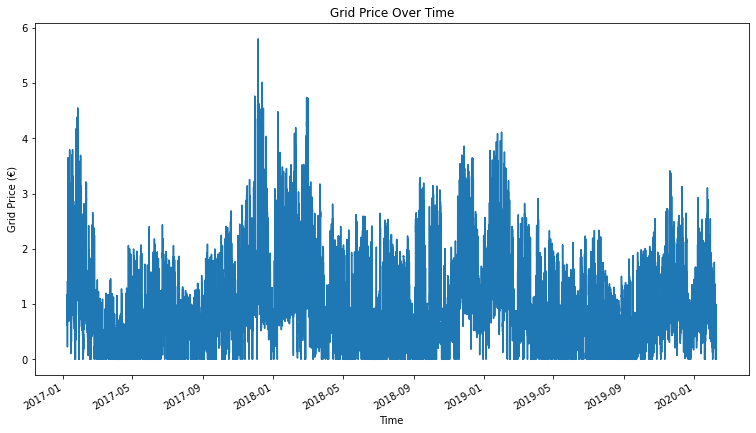

In [29]:
simulation["grid_price"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Grid Price (€)")
plt.title("Grid Price Over Time")
plt.show()

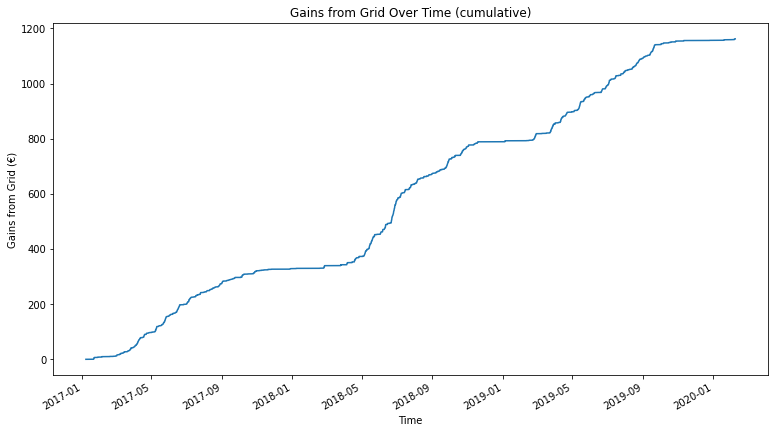

In [30]:
simulation["gains_from_grid"] = simulation["send_to_grid"] * simulation["price"] / 1000 / 4 # send to grid at a quarter of the market value
simulation["gains_from_grid"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Gains from Grid (€)")
plt.title("Gains from Grid Over Time (cumulative)")
plt.show()


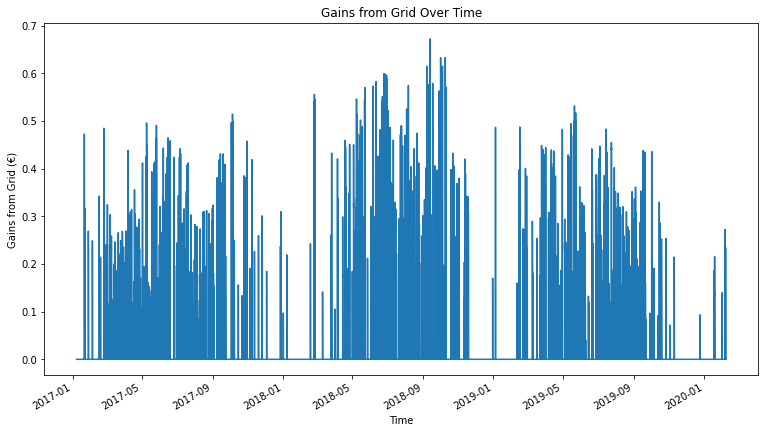

In [31]:
simulation["gains_from_grid"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Gains from Grid (€)")
plt.title("Gains from Grid Over Time")
plt.show()


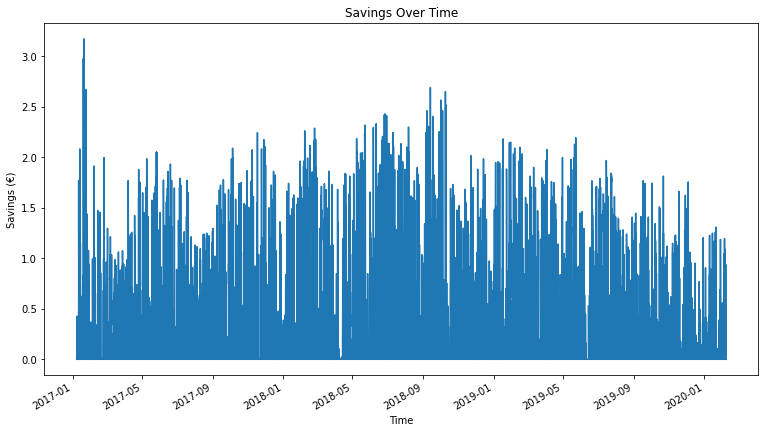

In [32]:
simulation["savings"] = simulation["energy"] * simulation["price"] / 1000 - simulation["grid_price"]
simulation["savings"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Savings (€)")
plt.title("Savings Over Time")
plt.show()


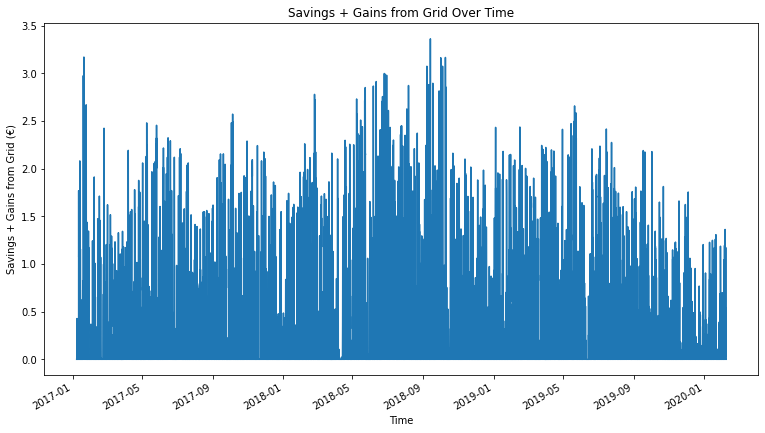

In [33]:
(simulation["savings"] + simulation["gains_from_grid"]).plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Savings + Gains from Grid (€)")
plt.title("Savings + Gains from Grid Over Time")
plt.show()


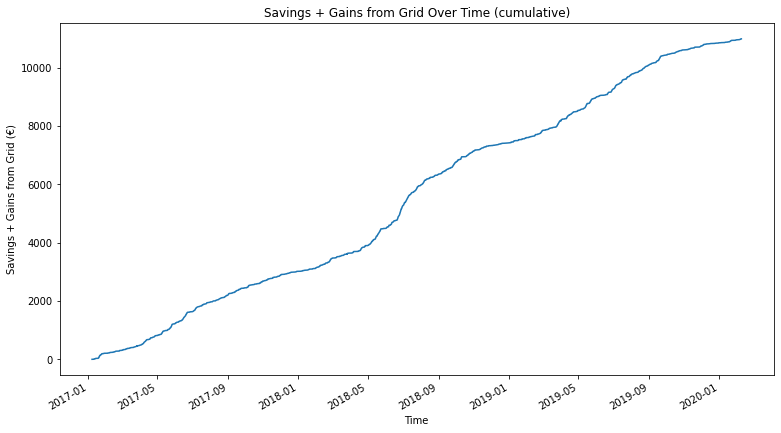

In [34]:
(simulation["savings"] + simulation["gains_from_grid"]).cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Savings + Gains from Grid (€)")
plt.title("Savings + Gains from Grid Over Time (cumulative)")
plt.show()


In [35]:
simulation.describe()

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings
count,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54049.000000,54055.000000,54055.000000,54055.0,54055.000000,54049.000000,54049.000000,54049.000000
mean,20.286665,20.276181,0.098689,4.178086,0.720980,0.030041,16.926209,1.647082,0.900752,0.720980,3.360456,0.0,0.002883,52.112591,0.021501,0.181845
std,10.314046,10.017546,0.221125,9.361553,2.823821,0.117659,10.917640,5.762580,0.681788,2.823821,7.499119,0.0,0.006459,12.355105,0.077967,0.423215
min,2.506500,2.785979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.010000,0.000000,0.000000
25%,12.824750,12.937007,0.000000,0.000000,0.000000,0.000000,11.162484,0.000000,0.500882,0.000000,0.000000,0.0,0.000000,44.720000,0.000000,0.000000
50%,17.027500,17.318855,0.000000,0.000000,0.000000,0.000000,14.886724,0.000000,0.752885,0.000000,0.000000,0.0,0.000000,51.750000,0.000000,0.000000
75%,25.404750,25.322304,0.017000,0.719712,0.000000,0.000000,21.752750,0.000000,1.154350,0.000000,0.719712,0.0,0.000497,60.070000,0.000000,0.035776
max,76.893000,76.088570,0.945000,40.007520,16.000000,0.666667,76.893000,37.760000,5.800835,16.000000,38.398752,0.0,0.027605,101.990000,0.672689,3.172275


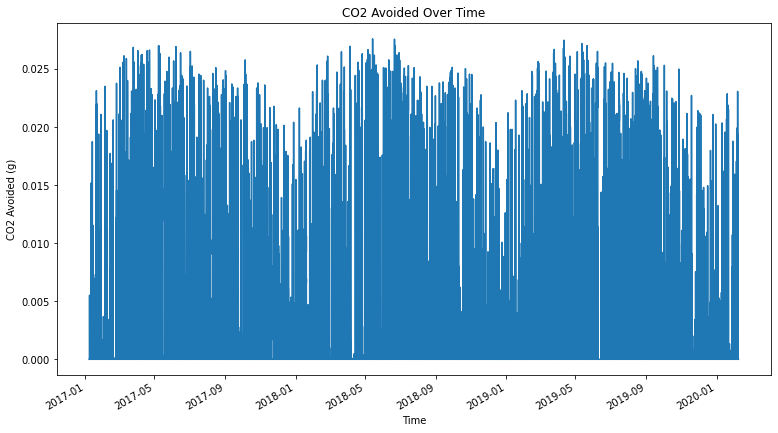

In [36]:
simulation["co2_avoided"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("CO2 Avoided (g)")
plt.title("CO2 Avoided Over Time")
plt.show()

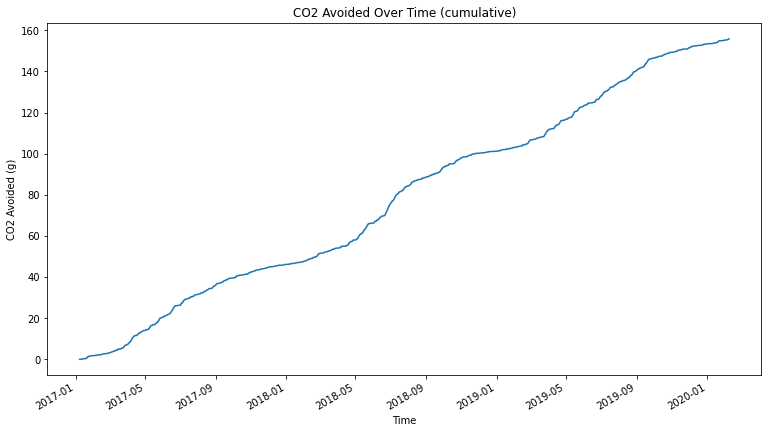

In [37]:
simulation["co2_avoided"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("CO2 Avoided (g)")
plt.title("CO2 Avoided Over Time (cumulative)")
plt.show()

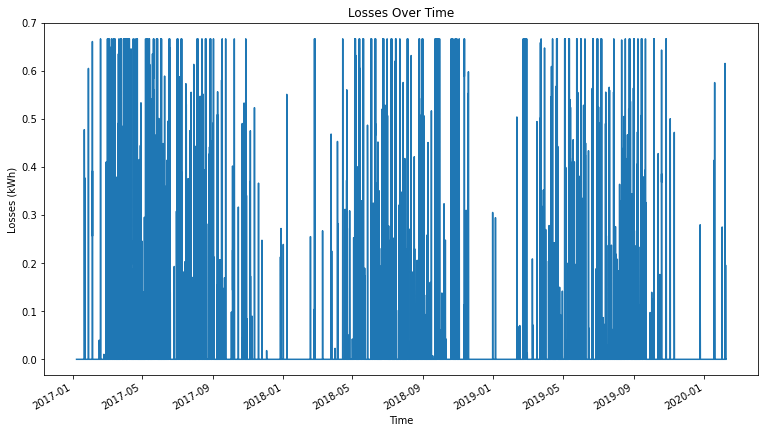

In [38]:
simulation["losses"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Losses (kWh)")
plt.title("Losses Over Time")
plt.show()


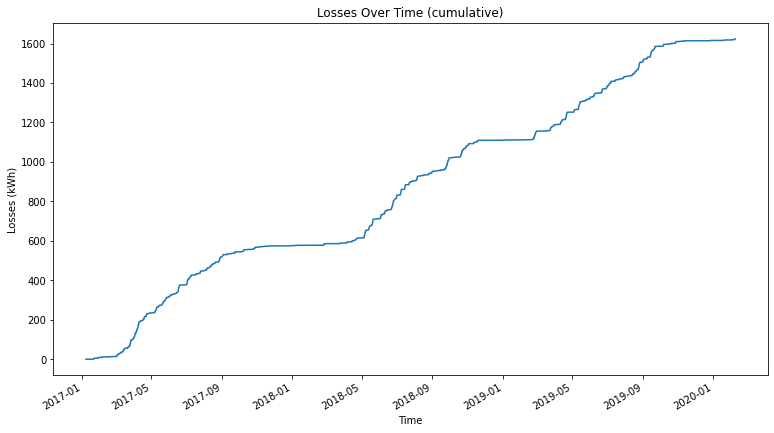

In [39]:
simulation["losses"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Losses (kWh)")
plt.title("Losses Over Time (cumulative)")
plt.show()


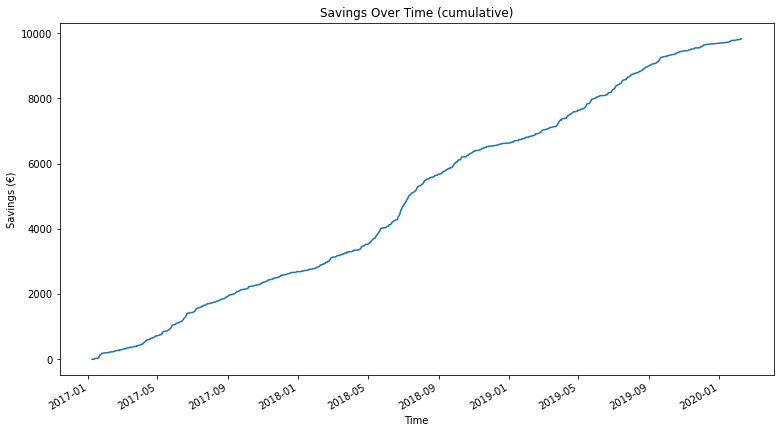

In [40]:
simulation["savings"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Savings (€)")
plt.title("Savings Over Time (cumulative)")
plt.show()


`TODO`: *pie charts* - **autoconsumo** e **autossuficiencia**

- **`autoconsumo`** = `consumed_from_production` - `saved_to_battery`
- **`excess_production`** = `send_to_grid`
- **`losses`** = (done)

-----

- **`autossuficiencia`** = `consumed_from_production` + `consumed_from_battery`
- **`gap_production`** = `grid_energy`
- **`losses`** = (done)

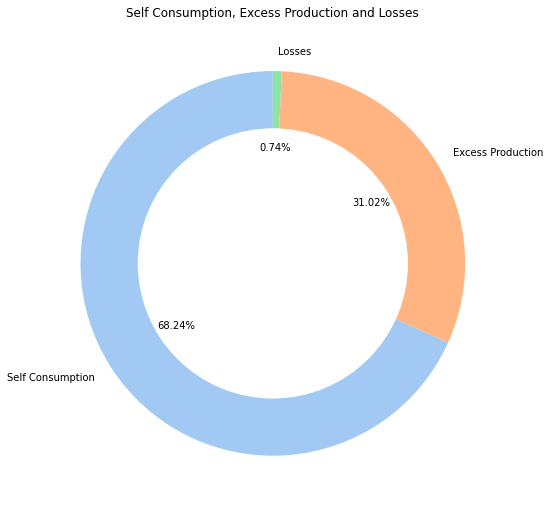

In [50]:
simulation["self_consumption"] = (simulation["consumed_from_production"] + simulation["saved_to_battery"]) / simulation["energy"]  # prod_consumed + stored

autoconsumo = simulation["self_consumption"].sum()
excess_production = (simulation["send_to_grid"] / simulation["energy"]).sum()
losses = (simulation["losses"] / simulation["energy"]).sum()

plt.figure(figsize=(12.8, 7.2))
colors = sns.color_palette("pastel")
plt.pie([autoconsumo, excess_production, losses], colors=colors, labels=["Self Consumption", "Excess Production", "Losses"], autopct="%1.2f%%",
        startangle=90)
fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0, 0), 0.7, color="white"))
plt.title("Self Consumption, Excess Production and Losses")
plt.tight_layout()
plt.show()


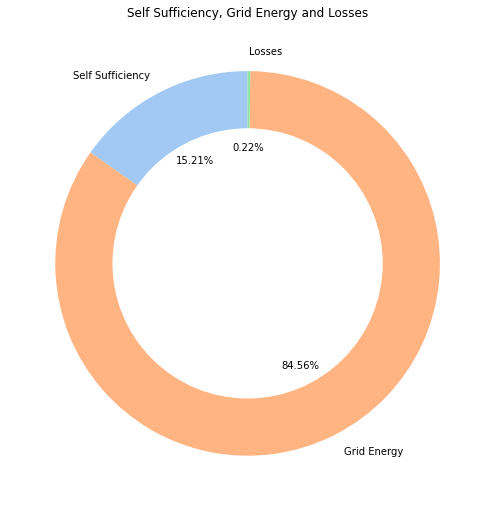

In [48]:
simulation["self_sufficiency"] = (simulation["consumed_from_production"] + simulation["consumed_from_battery"]) / simulation["energy"]

autossuficiencia = simulation["self_sufficiency"].sum()
gap_production = (simulation["grid_energy"] / simulation["energy"]).sum()
losses = (simulation["losses"] / simulation["energy"]).sum()

plt.figure(figsize=(12.8, 7.2))
colors = sns.color_palette("pastel")
plt.pie([autossuficiencia, gap_production, losses], colors=colors, labels=["Self Sufficiency", "Grid Energy", "Losses"], autopct="%1.2f%%",
        startangle=90)
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color="white"))
plt.title("Self Sufficiency, Grid Energy and Losses")
plt.tight_layout()
plt.show()


In [43]:
simulation[simulation["production"] >= simulation["energy"]]

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings,self_consumption,self_sufficiency
time,,,,,,,,,,,,,,,,,,
2017-01-21 09:30:00+00:00,15.4670,16.535599,0.512,21.676032,5.960671,0.248361,0.0,15.4670,0.0,5.960671,15.4670,0.0,0.014956,75.60,0.292326,1.169305,1.385380,1.0
2017-01-21 10:00:00+00:00,18.3740,18.007101,0.611,25.867296,7.193564,0.299732,0.0,18.3740,0.0,7.193564,18.3740,0.0,0.017848,84.00,0.385854,1.543416,1.391508,1.0
2017-01-21 10:30:00+00:00,19.5910,19.496422,0.676,28.619136,8.667011,0.361125,0.0,19.5910,0.0,8.667011,19.5910,0.0,0.019747,84.00,0.411411,1.645644,1.442398,1.0
2017-01-21 11:00:00+00:00,19.4455,19.739250,0.718,30.397248,10.513678,0.438070,0.0,19.4455,0.0,10.513678,19.4455,0.0,0.020974,83.04,0.403689,1.614754,1.540674,1.0
2017-01-21 11:30:00+00:00,19.5540,19.576218,0.744,31.497984,11.466225,0.477759,0.0,19.5540,0.0,11.466225,19.5540,0.0,0.021734,83.04,0.405941,1.623764,1.586388,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-06 15:30:00+00:00,12.4815,13.165052,0.631,26.714016,13.663215,0.569301,0.0,12.4815,0.0,13.663215,12.4815,0.0,0.018433,37.94,0.118387,0.473548,2.094677,1.0
2020-02-06 16:00:00+00:00,13.0060,12.347885,0.537,22.734432,9.339295,0.389137,0.0,13.0060,0.0,9.339295,13.0060,0.0,0.015687,38.06,0.123752,0.495008,1.718076,1.0
2020-02-06 16:30:00+00:00,10.5640,12.425087,0.382,16.172352,5.384018,0.224334,0.0,10.5640,0.0,5.384018,10.5640,0.0,0.011159,38.06,0.100516,0.402066,1.509657,1.0


In [44]:
simulation.describe()

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings,self_consumption,self_sufficiency
count,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54049.000000,54055.000000,54055.000000,54055.0,54055.000000,54049.000000,54049.000000,54049.000000,54055.000000,54055.000000
mean,20.286665,20.276181,0.098689,4.178086,0.720980,0.030041,16.926209,1.647082,0.900752,0.720980,3.360456,0.0,0.002883,52.112591,0.021501,0.181845,0.206603,0.152485
std,10.314046,10.017546,0.221125,9.361553,2.823821,0.117659,10.917640,5.762580,0.681788,2.823821,7.499119,0.0,0.006459,12.355105,0.077967,0.423215,0.513981,0.321516
min,2.506500,2.785979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000
25%,12.824750,12.937007,0.000000,0.000000,0.000000,0.000000,11.162484,0.000000,0.500882,0.000000,0.000000,0.0,0.000000,44.720000,0.000000,0.000000,0.000000,0.000000
50%,17.027500,17.318855,0.000000,0.000000,0.000000,0.000000,14.886724,0.000000,0.752885,0.000000,0.000000,0.0,0.000000,51.750000,0.000000,0.000000,0.000000,0.000000
75%,25.404750,25.322304,0.017000,0.719712,0.000000,0.000000,21.752750,0.000000,1.154350,0.000000,0.719712,0.0,0.000497,60.070000,0.000000,0.035776,0.034695,0.034695
max,76.893000,76.088570,0.945000,40.007520,16.000000,0.666667,76.893000,37.760000,5.800835,16.000000,38.398752,0.0,0.027605,101.990000,0.672689,3.172275,7.383403,1.000000


In [45]:
simulation.sum()

energy                      1.096596e+06
energy_pred                 1.096029e+06
Dni                         5.334619e+03
production                  2.258464e+05
battery_charge              3.897255e+04
losses                      1.623856e+03
grid_energy                 9.149462e+05
send_to_grid                8.903300e+04
grid_price                  4.868476e+04
saved_to_battery            3.897255e+04
consumed_from_production    1.816495e+05
consumed_from_battery       0.000000e+00
co2_avoided                 1.558340e+02
price                       2.816633e+06
gains_from_grid             1.162126e+03
savings                     9.828546e+03
self_consumption            1.116792e+04
self_sufficiency            8.242602e+03
dtype: float64